# EvolvePro - Local Environment Setup

This notebook is adapted to run in your local environment instead of Google Colab.

## Setup: Path Configuration

In [8]:
import os
import sys

# Add the project root to Python path
project_root = os.path.abspath('..')
sys.path.insert(0, project_root)

# Set up paths for local environment
base_dir = project_root
output_dir = os.path.join(base_dir, 'output')
rounds_data_dir = os.path.join(base_dir, 'colab', 'rounds_data')

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f'Project root: {project_root}')
print(f'Output directory: {output_dir}')
print(f'Rounds data directory: {rounds_data_dir}')

Project root: /Users/jmsung/projects/EvolvePro
Output directory: /Users/jmsung/projects/EvolvePro/output
Rounds data directory: /Users/jmsung/projects/EvolvePro/colab/rounds_data


## Import Required Libraries

In [9]:
# Import EvolvePro modules
from evolvepro.src.process import generate_wt, generate_single_aa_mutants, suggest_initial_mutants
from evolvepro.src.evolve import evolve_experimental
from evolvepro.src.plot import read_exp_data, plot_variants_by_iteration

print('All imports successful!')

All imports successful!


## Process: Generate Wild Type and Mutants

In [10]:
# Generate wild type sequence
wt_sequence = 'MAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIRILTGDKVTVELTPYDLSKGRIVFRSR'
wt_fasta_path = os.path.join(output_dir, 'kelsic_WT.fasta')
generate_wt(wt_sequence, output_file=wt_fasta_path)

# Generate single amino acid mutants
mutants_fasta_path = os.path.join(output_dir, 'kelsic.fasta')
generate_single_aa_mutants(wt_fasta_path, output_file=mutants_fasta_path)

print(f'Generated wild type: {wt_fasta_path}')
print(f'Generated mutants: {mutants_fasta_path}')

Number of mutants: 1369
Generated wild type: /Users/jmsung/projects/EvolvePro/output/kelsic_WT.fasta
Generated mutants: /Users/jmsung/projects/EvolvePro/output/kelsic.fasta


In [11]:
# Suggest initial mutants
suggest_initial_mutants(mutants_fasta_path, num_mutants=12, random_seed=42)


Suggested 12 mutants for testing:
1. R23K
2. T58E
3. I36D
4. V31C
5. I7A
6. K3F
7. Q10P
8. G38E
9. E4M
10. D61W
11. E4Y
12. R23N


## PLM: Extract Embeddings

In [12]:
# Extract ESM embeddings with MPS support for Apple Silicon
import subprocess

embeddings_name = 'kelsic_esm1b_t33_650M_UR50S'
esm_script = os.path.join(project_root, 'evolvepro', 'plm', 'esm', 'extract_mps.py')

cmd = [
    'python', esm_script,
    'esm1b_t33_650M_UR50S',
    mutants_fasta_path,
    embeddings_name,
    '--toks_per_batch', '512',
    '--include', 'mean',
    '--concatenate_dir', output_dir
]

print('Running ESM extraction with MPS support...')
print(f'Command: {' '.join(cmd)}')

try:
    result = subprocess.run(cmd, cwd=project_root, capture_output=True, text=True)
    if result.returncode == 0:
        print('ESM extraction completed successfully!')
        print('Check the output above to see if MPS (GPU) was used.')
    else:
        print(f'ESM extraction failed with error: {result.stderr}')
except Exception as e:
    print(f'Error running ESM extraction: {e}')

Running ESM extraction with MPS support...
Command: python /Users/jmsung/projects/EvolvePro/evolvepro/plm/esm/extract_mps.py esm1b_t33_650M_UR50S /Users/jmsung/projects/EvolvePro/output/kelsic.fasta kelsic_esm1b_t33_650M_UR50S --toks_per_batch 512 --include mean --concatenate_dir /Users/jmsung/projects/EvolvePro/output
ESM extraction completed successfully!
Check the output above to see if MPS (GPU) was used.


## Run EVOLVEpro

In [13]:
# Set up parameters for evolution
protein_name = 'kelsic'
embeddings_base_path = output_dir
embeddings_file_name = f'{embeddings_name}.csv'
round_base_path = rounds_data_dir
number_of_variants = 12
rename_WT = False

print(f'Protein: {protein_name}')
print(f'Embeddings: {os.path.join(embeddings_base_path, embeddings_file_name)}')
print(f'Rounds data: {round_base_path}')
print(f'WT fasta: {wt_fasta_path}')

Protein: kelsic
Embeddings: /Users/jmsung/projects/EvolvePro/output/kelsic_esm1b_t33_650M_UR50S.csv
Rounds data: /Users/jmsung/projects/EvolvePro/colab/rounds_data
WT fasta: /Users/jmsung/projects/EvolvePro/output/kelsic_WT.fasta


### Round 1

In [14]:
round_name = 'Round1'
round_file_names = ['kelsic_Round1.xlsx']

this_round_variants, df_test, df_sorted_all = evolve_experimental(
    protein_name,
    round_name,
    embeddings_base_path,
    embeddings_file_name,
    round_base_path,
    round_file_names,
    wt_fasta_path,
    rename_WT,
    number_of_variants,
    output_dir
)

print(f'Round 1 completed. Selected variants: {this_round_variants}')

Processing kelsic - Round1
Embeddings loaded: (1369, 1280)
Loaded experimental data for kelsic_Round1.xlsx: (12, 3)
iteration shape: (12, 2)
Labels shape: (1369, 5)
Embeddings and labels are aligned
(1357,)

Tested variants in this round: 12
93      D61W
161      E4M
170      E4Y
288     G38E
382     I36D
456      I7A
498      K3F
886     Q10P
901     R23K
904     R23N
1181    T58E
1236    V31C
Name: variant, dtype: object

Top 12 variants predicted by the model:
     variant    y_pred  y_actual  y_actual_scaled  y_actual_binary  \
343     H30C  0.947953       NaN              NaN              NaN   
191      E8C  0.946802       NaN              NaN              NaN   
1245    V31M  0.945428       NaN              NaN              NaN   
160      E4L  0.941292       NaN              NaN              NaN   
58       D5C  0.940435       NaN              NaN              NaN   
1255    V32C  0.939753       NaN              NaN              NaN   
1065    T12C  0.938928       NaN          

/Users/jmsung/projects/EvolvePro/evolvepro/src/model.py:303: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


### Round 2

In [15]:
round_name = 'Round2'
round_file_names = ['kelsic_Round1.xlsx', 'kelsic_Round2.xlsx']

this_round_variants, df_test, df_sorted_all = evolve_experimental(
    protein_name,
    round_name,
    embeddings_base_path,
    embeddings_file_name,
    round_base_path,
    round_file_names,
    wt_fasta_path,
    rename_WT,
    number_of_variants,
    output_dir
)

print(f'Round 2 completed. Selected variants: {this_round_variants}')

Processing kelsic - Round2
Embeddings loaded: (1369, 1280)
Loaded experimental data for kelsic_Round1.xlsx: (12, 3)
Loaded experimental data for kelsic_Round2.xlsx: (12, 3)
iteration shape: (24, 2)
Labels shape: (1369, 5)
Embeddings and labels are aligned
(1345,)

Tested variants in this round: 24
66       D5M
93      D61W
155      E4F
157      E4H
160      E4L
161      E4M
162      E4N
164      E4Q
168      E4V
170      E4Y
191      E8C
202      E8Q
288     G38E
382     I36D
456      I7A
498      K3F
886     Q10P
901     R23K
904     R23N
1046    S71C
1065    T12C
1074    T12M
1181    T58E
1236    V31C
Name: variant, dtype: object

Top 12 variants predicted by the model:
     variant    y_pred  y_actual  y_actual_scaled  y_actual_binary  \
169      E4W  1.002710       NaN              NaN              NaN   
73       D5V  0.982920       NaN              NaN              NaN   
60       D5F  0.980387       NaN              NaN              NaN   
701      M1W  0.976602       NaN       

/Users/jmsung/projects/EvolvePro/evolvepro/src/model.py:303: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


### Round 3

In [16]:
round_name = 'Round3'
round_file_names = ['kelsic_Round1.xlsx', 'kelsic_Round2.xlsx', 'kelsic_Round3.xlsx']

this_round_variants, df_test, df_sorted_all = evolve_experimental(
    protein_name,
    round_name,
    embeddings_base_path,
    embeddings_file_name,
    round_base_path,
    round_file_names,
    wt_fasta_path,
    rename_WT,
    number_of_variants,
    output_dir
)

print(f'Round 3 completed. Selected variants: {this_round_variants}')

Processing kelsic - Round3
Embeddings loaded: (1369, 1280)
Loaded experimental data for kelsic_Round1.xlsx: (12, 3)
Loaded experimental data for kelsic_Round2.xlsx: (12, 3)
Loaded experimental data for kelsic_Round3.xlsx: (12, 3)
iteration shape: (36, 2)
Labels shape: (1369, 5)
Embeddings and labels are aligned
(1333,)

Tested variants in this round: 36
58       D5C
60       D5F
63       D5I
65       D5L
66       D5M
67       D5N
73       D5V
75       D5Y
93      D61W
126     E25Q
153      E4C
155      E4F
157      E4H
158      E4I
160      E4L
161      E4M
162      E4N
164      E4Q
168      E4V
169      E4W
170      E4Y
191      E8C
202      E8Q
288     G38E
382     I36D
456      I7A
498      K3F
701      M1W
886     Q10P
901     R23K
904     R23N
1046    S71C
1065    T12C
1074    T12M
1181    T58E
1236    V31C
Name: variant, dtype: object

Top 12 variants predicted by the model:
    variant    y_pred  y_actual  y_actual_scaled  y_actual_binary dist_metric  \
72      D5T  1.002908    

/Users/jmsung/projects/EvolvePro/evolvepro/src/model.py:303: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


### Round 4

In [17]:
round_name = 'Round4'
round_file_names = ['kelsic_Round1.xlsx', 'kelsic_Round2.xlsx', 'kelsic_Round3.xlsx', 'kelsic_Round4.xlsx']

this_round_variants, df_test, df_sorted_all = evolve_experimental(
    protein_name,
    round_name,
    embeddings_base_path,
    embeddings_file_name,
    round_base_path,
    round_file_names,
    wt_fasta_path,
    rename_WT,
    number_of_variants,
    output_dir
)

print(f'Round 4 completed. Selected variants: {this_round_variants}')

Processing kelsic - Round4
Embeddings loaded: (1369, 1280)
Loaded experimental data for kelsic_Round1.xlsx: (12, 3)
Loaded experimental data for kelsic_Round2.xlsx: (12, 3)
Loaded experimental data for kelsic_Round3.xlsx: (12, 3)
Loaded experimental data for kelsic_Round4.xlsx: (12, 3)
iteration shape: (48, 2)
Labels shape: (1369, 5)
Embeddings and labels are aligned
(1321,)

Tested variants in this round: 48
57       D5A
58       D5C
60       D5F
62       D5H
63       D5I
65       D5L
66       D5M
67       D5N
69       D5Q
71       D5S
72       D5T
73       D5V
75       D5Y
93      D61W
126     E25Q
134     E27C
141     E27L
142     E27M
145     E27Q
153      E4C
155      E4F
157      E4H
158      E4I
160      E4L
161      E4M
162      E4N
164      E4Q
167      E4T
168      E4V
169      E4W
170      E4Y
191      E8C
202      E8Q
288     G38E
382     I36D
456      I7A
498      K3F
701      M1W
712     M21L
886     Q10P
901     R23K
904     R23N
1046    S71C
1065    T12C
1074    T12M
11

/Users/jmsung/projects/EvolvePro/evolvepro/src/model.py:303: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


### Round 5

In [18]:
round_name = 'Round5'
round_file_names = ['kelsic_Round1.xlsx', 'kelsic_Round2.xlsx', 'kelsic_Round3.xlsx', 'kelsic_Round4.xlsx', 'kelsic_Round5.xlsx']

this_round_variants, df_test, df_sorted_all = evolve_experimental(
    protein_name,
    round_name,
    embeddings_base_path,
    embeddings_file_name,
    round_base_path,
    round_file_names,
    wt_fasta_path,
    rename_WT,
    number_of_variants,
    output_dir
)

print(f'Round 5 completed. Selected variants: {this_round_variants}')

Processing kelsic - Round5
Embeddings loaded: (1369, 1280)
Loaded experimental data for kelsic_Round1.xlsx: (12, 3)
Loaded experimental data for kelsic_Round2.xlsx: (12, 3)
Loaded experimental data for kelsic_Round3.xlsx: (12, 3)
Loaded experimental data for kelsic_Round4.xlsx: (12, 3)
Loaded experimental data for kelsic_Round5.xlsx: (12, 3)
iteration shape: (60, 2)
Labels shape: (1369, 5)
Embeddings and labels are aligned
(1309,)

Tested variants in this round: 60
57       D5A
58       D5C
60       D5F
62       D5H
63       D5I
65       D5L
66       D5M
67       D5N
68       D5P
69       D5Q
71       D5S
72       D5T
73       D5V
74       D5W
75       D5Y
93      D61W
126     E25Q
134     E27C
141     E27L
142     E27M
145     E27Q
152      E4A
153      E4C
155      E4F
157      E4H
158      E4I
160      E4L
161      E4M
162      E4N
163      E4P
164      E4Q
166      E4S
167      E4T
168      E4V
169      E4W
170      E4Y
191      E8C
193      E8F
195      E8H
197      E8K
202      E

/Users/jmsung/projects/EvolvePro/evolvepro/src/model.py:303: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_train, df_test])


## Plot Results

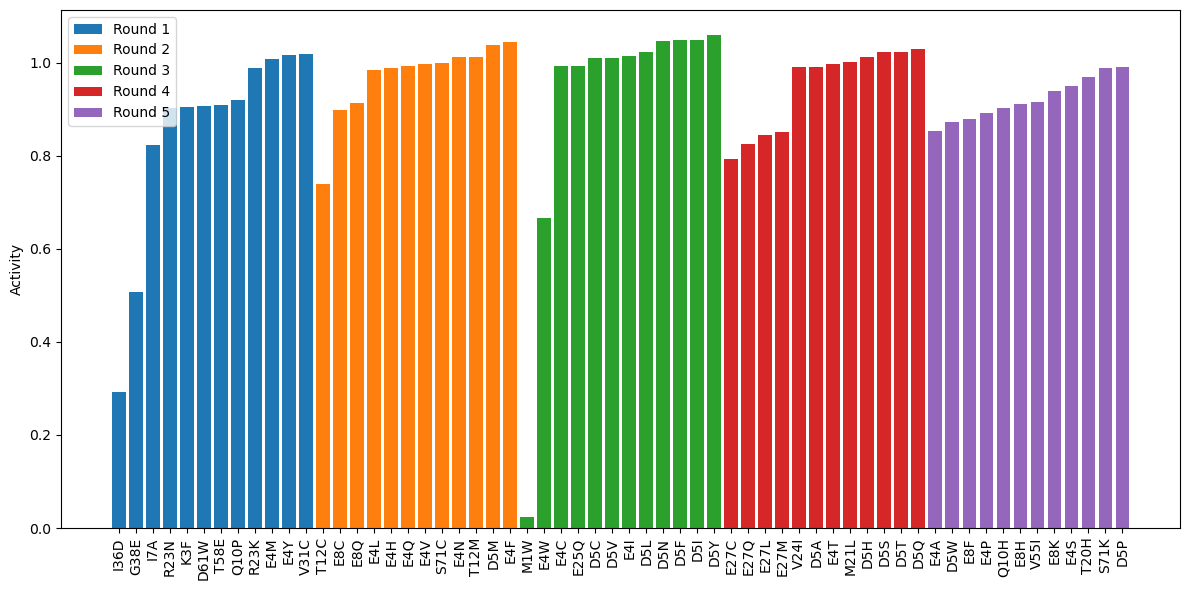

Plots generated successfully!
Output directory: /Users/jmsung/projects/EvolvePro/output


In [19]:
# Read experimental data and create plots
round_file_names = ['kelsic_Round1.xlsx', 'kelsic_Round2.xlsx', 'kelsic_Round3.xlsx', 'kelsic_Round4.xlsx', 'kelsic_Round5.xlsx']

df = read_exp_data(round_base_path, round_file_names, wt_fasta_path)
plot_variants_by_iteration(df, activity_column='activity', output_dir=output_dir, output_file='kelsic')

print('Plots generated successfully!')
print(f'Output directory: {output_dir}')